# Ensuring Model Fairness in Recidivism Prediction

Our primary focus in this notebook is to apply and evaluate various mitigation techniques to ensure fairness in our recidivism prediction model. Fairness in predictive modeling, especially in the criminal justice system, is crucial to avoid reinforcing biases and inequalities. This notebook outlines a comprehensive approach to address potential biases and ensure our model's predictions are as fair and unbiased as possible.

Notebook Outline:

1. **Data Loading and Preparation for Fairness Analysis:**
We'll start by loading and preparing our dataset, paying special attention to fairness considerations. A critical part of this preparation involves investigating the impact of sensitive features such as sex and race. We'll explore how removing these features affects statistical parity and equalized odds, as well as overall model performance. This step is crucial for understanding the inherent biases in the data and how they might influence the model's predictions.

2. **Investigating Class Imbalance Related to Sensitive Features:**
Class imbalance can significantly skew model predictions, especially for minority groups. We will investigate the distribution of our sensitive features and apply resampling techniques, such as upsampling and downsampling, to address any imbalances. This step aims to ensure that our model is trained on a balanced representation of all groups, enhancing its fairness.

3. **In-processing Technique: Data Reweighting:**
We will implement in-processing techniques, specifically data reweighting, to reduce bias during the model training process. By adjusting the weights of instances in the training data, we aim to minimize bias towards any particular group, ensuring a more equitable model learning process.

4. **Testing Exponentiated Gradients for Fair Prediction:**
Exponentiated Gradients is a powerful technique for reducing bias in predictive models. We will apply this method to achieve fairness in terms of constraint like demographic parity, without significantly compromising the model's accuracy.

5. **Explaining Model Predictions with Global and Local Techniques:**
Understanding why a model makes certain predictions is as important as the predictions themselves. We'll use global explainability techniques, like feature importance based on odds ratios, and local method LIME, to interpret our model's predictions. This transparency is key in validating the fairness and reliability of the model.

6. **Investigating Model Safety and Uncertainty:**
Finally, we'll explore the model's safety by estimating epistemic uncertainty using the Bootstrapping technique. This approach will help us understand the confidence in the model's predictions and identify areas where the model may be less certain, guiding us in making more cautious decisions.

Let's dive in.

## 1. Data Loading and Preparation for Fairness Analysis

In [1]:
import pandas as pd

# Load the data
file_path = 'data/df_cleaned.csv'
df = pd.read_csv(file_path)

df.head()

,sex,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,age_cat_25-45,age_cat_Greaterthan45,age_cat_Lessthan25,charge_degree,race
0,1,-0.14965,-0.190564,-0.247266,-0.709995,1,1,0,0,1,1
1,1,-0.14965,-0.190564,1.827564,0.110444,1,0,0,1,1,1
2,1,-0.14965,-0.190564,-0.247266,2.161540,1,1,0,0,1,0
3,0,-0.14965,-0.190564,-0.247266,-0.709995,0,1,0,0,0,0
4,1,-0.14965,-0.190564,-0.247266,-0.709995,0,1,0,0,1,0


In [2]:
# Initialize a DataFrame to store the results of our analysis for esay comparison
results_df = pd.DataFrame(columns=[
    'mitigation_technique', 
    'model_accuracy',
    'AUC', 
    'f1', 
    'precision', 
    'recall', 
    'statistical_parity_sex', 
    'equalized_odds_sex',
    'statistical_parity_race',
    'equalized_odds_race',
])

# Function to update the DataFrame with new results
def update_results(mitigation_technique,
                   model_accuracy, 
                   AUC, 
                   f1, 
                   precision, 
                   recall, 
                   statistical_parity_sex, 
                   equalized_odds_sex, 
                   statistical_parity_race, 
                   equalized_odds_race
                  ):
    new_entry = {
        'mitigation_technique': mitigation_technique, 
        'model_accuracy': model_accuracy, 
        'AUC': AUC, 
        'f1': f1, 
        'precision': precision, 
        'recall': recall, 
        'statistical_parity_sex': statistical_parity_sex, 
        'equalized_odds_sex': equalized_odds_sex,
        'statistical_parity_race': statistical_parity_race, 
        'equalized_odds_race': equalized_odds_race, 
    }
    return results_df.append(new_entry, ignore_index=True)

# Example usage after evaluating a model
# results_df = update_results(
#     mitigation_technique='upsampling',
#     model_accuracy=0.85,  
#     AUC=0.90,  
#     f1=0.87, 
#     precision=0.88,  
#     recall=0.86, 
#     statistical_parity_sex =0.89, 
#     equalized_odds_sex =0.99,
#     statistical_parity_race = 0.23, 
#     equalized_odds_race =0.33
# )

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from fairness_metrics import statistical_parity, equalized_odds
from metricFrame_vis import analyze_metrics_using_metricFrame
import matplotlib.pyplot as plt
import seaborn as sns


### 1.1 Train GradientBoosting for testing

In [4]:
# Data Preparation
X = df.drop(['two_year_recid'], axis=1)
y = df['two_year_recid']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Gradient Boosting classifier with best parameters found
gb_classifier = GradientBoostingClassifier(learning_rate=0.01, 
                                           max_depth=3, 
                                           n_estimators=300, 
                                           random_state=42)

# Fit the grid search to the data
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=300,
                           random_state=42)

In [5]:
# Evaluate the model on the test set
y_pred_gb = gb_classifier.predict(X_test)

model_accuracy_gb = accuracy_score(y_test, y_pred_gb)
AUC = roc_auc_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)

print("Test set accuracy: ", model_accuracy_gb)
print("Classification report:\n", classification_report(y_test, y_pred_gb))

Test set accuracy:  0.6603535353535354
Classification report:
               precision    recall  f1-score   support

           0       0.67      0.73      0.70       849
           1       0.65      0.58      0.61       735

    accuracy                           0.66      1584
   macro avg       0.66      0.65      0.66      1584
weighted avg       0.66      0.66      0.66      1584



In [6]:
print("AUC:", roc_auc_score(y_test, y_pred_gb))

AUC: 0.654931371842023


### 1.2 Statistical Parity and Equalized Odds

The objective is to ensure that the model do not propagate or exacerbate existing biases against certain groups. This includes careful consideration of how these features are used, how the models are evaluated (including fairness metrics), and how the results are interpreted and applied.

#### 1.2.1 Race analysis

In [7]:
statistical_parity_race = statistical_parity(y_test, y_pred_gb, X_test['race'])
equalized_odds_race = equalized_odds(y_test, y_pred_gb, X_test['race'])

print(statistical_parity_race)
print(equalized_odds_race)

{'Statistical Parity Difference': 0.23, 'Statistical Parity ratio': 0.544}
{'Equalized Odds Difference': 0.263, 'Equalized Odds Ratio': 0.568}


array([[<Axes: title={'center': 'accuracy'}, xlabel='race'>,
        <Axes: title={'center': 'precision'}, xlabel='race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='race'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='race'>,
        <Axes: title={'center': 'selection rate'}, xlabel='race'>,
        <Axes: xlabel='race'>],
       [<Axes: xlabel='race'>, <Axes: xlabel='race'>,
        <Axes: xlabel='race'>]], dtype=object)

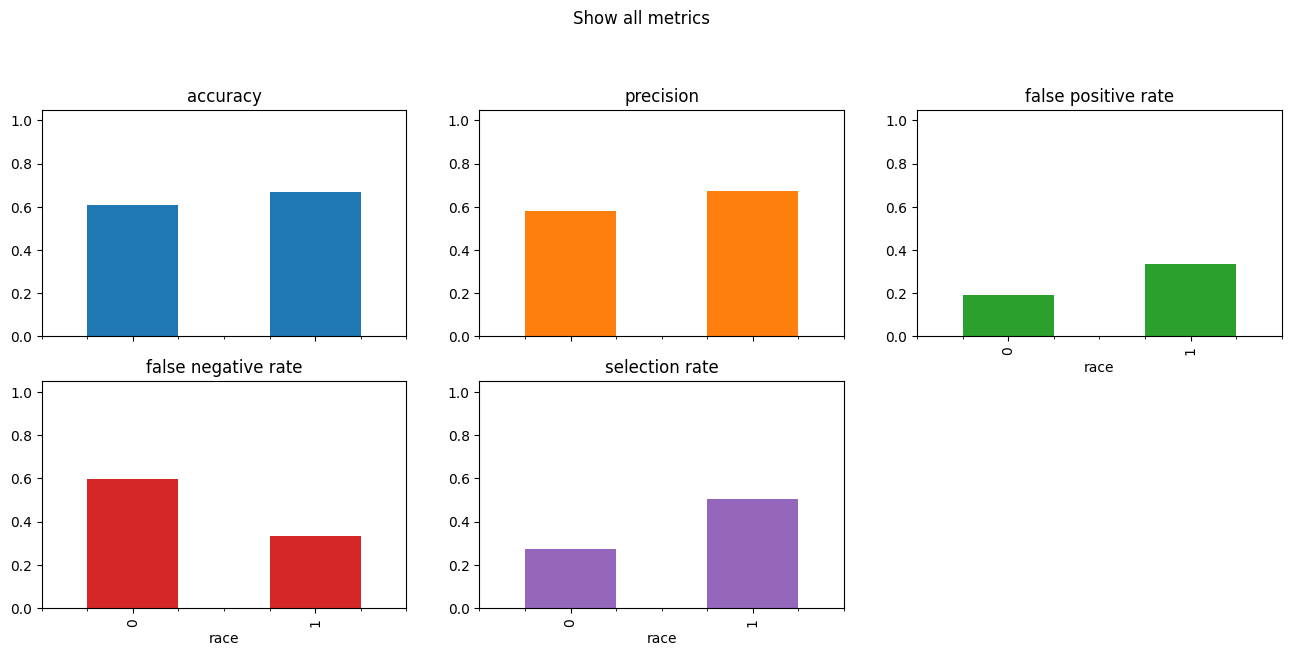

In [8]:
analyze_metrics_using_metricFrame(y_test, y_pred_gb, X_test['race'])

#### 1.2.2 Sex analysis

In [9]:
statistical_parity_sex = statistical_parity(y_test, y_pred_gb, X_test['sex'])
equalized_odds_sex = equalized_odds(y_test, y_pred_gb, X_test['sex'])

print(statistical_parity_sex)
print(equalized_odds_sex)

{'Statistical Parity Difference': 0.2, 'Statistical Parity ratio': 0.56}
{'Equalized Odds Difference': 0.244, 'Equalized Odds Ratio': 0.605}


array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='sex'>,
        <Axes: xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

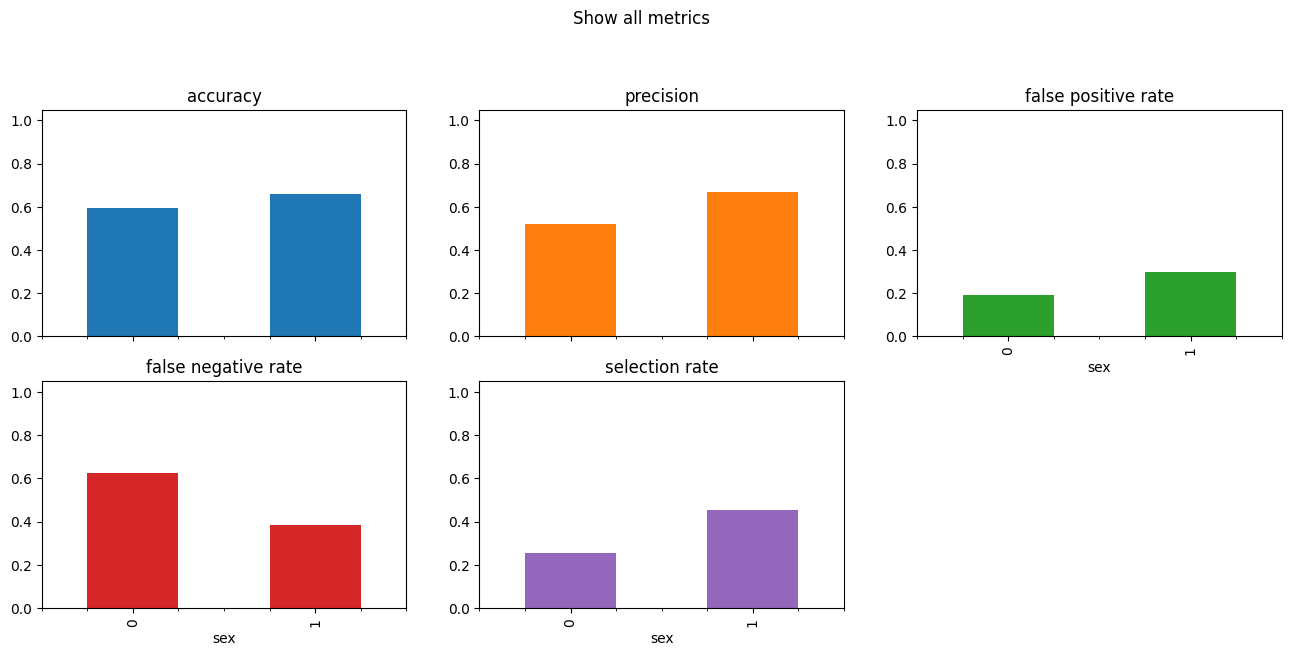

In [10]:
analyze_metrics_using_metricFrame(y_test, y_pred_gb, X_test['sex'])

**Note:** the following explanation is relevant every time we use statistical parity and equalized odds and for the sex feature too.


**Statistical Parity Difference (SPD)**
- SPD measures the difference in the rate of positive outcomes between African-American and Caucasian individuals. A value of 0.23 suggests that the model's positive predictions (e.g., predicting recidivism) are 25% more likely for one group over the other. **This is a substantial disparity, indicating a bias in the model's predictions.**

**Statistical Parity Ratio**
- This is the ratio of selection rates (rate of positive outcomes) between groups. A value less than 1 (0.54 in this case) indicates that the model is less likely to predict a positive outcome for the African-American group compared to the Caucasian group. **The farther this value is from 1, the greater the disparity.**

**Equalized Odds Difference (EOD)**
- EOD measures the disparity in error rates (both false positives and false negatives) between groups. A value of 0.26 suggests significant differences in how errors are distributed between African-American and Caucasian individuals. This means one group is more likely to be incorrectly classified than the other, either as false positives (wrongly predicting recidivism) or false negatives (failing to predict actual recidivism).

**Equalized Odds Ratio**
- This is the ratio of odds of both true positive rate and false positive rate being equal for all groups. A value of 0.43 indicates **significant inequality in the error rates between the groups**, suggesting that the model does not treat them equally in terms of both false positives and false negatives.

**Implication**
These metrics reveal significant disparities in the model's predictions across racial lines. Specifically, *the model is more likely to predict recidivism for African-American individuals than for Caucasian individuals*, and the error rates (false positives and negatives) are not equally distributed across these groups.

Such disparities are especially concerning in the context of criminal justice, where biased predictions can have serious real-world consequences.

In [11]:
# Saving the results
results_df = update_results(
    mitigation_technique='none',
    model_accuracy=model_accuracy_gb,  
    AUC= AUC,  
    f1= f1, 
    precision= precision,  
    recall= recall, 
    statistical_parity_sex = statistical_parity_sex, 
    equalized_odds_sex = equalized_odds_sex,
    statistical_parity_race = statistical_parity_race, 
    equalized_odds_race = equalized_odds_race
)

/var/folders/h5/r3ldzs6x5bxb71r4t20ydphh0000gn/T/ipykernel_98906/2976667666.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return results_df.append(new_entry, ignore_index=True)


In [12]:
pd.set_option("display.max_colwidth", -1)

/var/folders/h5/r3ldzs6x5bxb71r4t20ydphh0000gn/T/ipykernel_98906/2475433900.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


In [13]:
results_df

,mitigation_technique,model_accuracy,AUC,f1,precision,recall,statistical_parity_sex,equalized_odds_sex,statistical_parity_race,equalized_odds_race
0,none,0.660354,0.654931,0.61295,0.650382,0.579592,"{'Statistical Parity Difference': 0.2, 'Statistical Parity ratio': 0.56}","{'Equalized Odds Difference': 0.244, 'Equalized Odds Ratio': 0.605}","{'Statistical Parity Difference': 0.23, 'Statistical Parity ratio': 0.544}","{'Equalized Odds Difference': 0.263, 'Equalized Odds Ratio': 0.568}"


#### 1.2.3 Feature importance

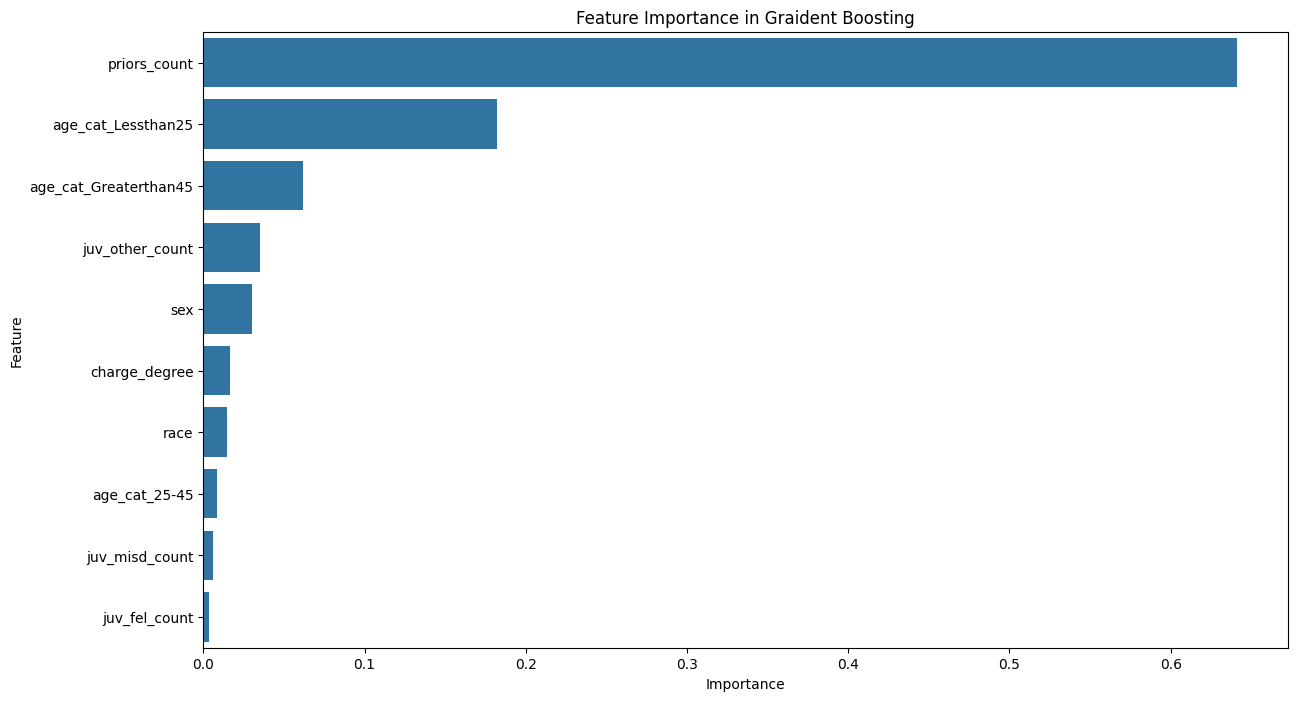

In [14]:
feature_importance = pd.DataFrame({
    'features': X.columns,
    'coefficients': gb_classifier.feature_importances_
})

feature_importance = feature_importance.sort_values(by='coefficients', ascending=False)


# Plotting the feature importance
plt.figure(figsize=(14, 8))
sns.barplot(x='coefficients', y='features', data=feature_importance)
plt.title('Feature Importance in Graident Boosting')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### 1.3 Investigating the impact of removing sex and race

In [15]:
# Data Preparation
X = df.drop(['two_year_recid'], axis=1)
y = df['two_year_recid']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Remove sex and race from the training data
X_train = X_train.drop(['sex', 'race'], axis=1)
sensitive_feature_race = X_test['race']
sensitive_feature_sex = X_test['sex']
X_test = X_test.drop(['sex', 'race'], axis=1)

# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(learning_rate=0.01, 
                                           max_depth=3, 
                                           n_estimators=300, 
                                           random_state=42)

# Fit the grid search to the data
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=300,
                           random_state=42)

In [16]:
# Evaluate the model on the test set
y_pred_gb = gb_classifier.predict(X_test)

model_accuracy_gb = accuracy_score(y_test, y_pred_gb)
AUC = roc_auc_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)

print("Test set accuracy: ", model_accuracy_gb)
print("Classification report:\n", classification_report(y_test, y_pred_gb))

Test set accuracy:  0.6553030303030303
Classification report:
               precision    recall  f1-score   support

           0       0.66      0.72      0.69       849
           1       0.64      0.58      0.61       735

    accuracy                           0.66      1584
   macro avg       0.65      0.65      0.65      1584
weighted avg       0.65      0.66      0.65      1584



In [17]:
print("AUC:", roc_auc_score(y_test, y_pred_gb))

AUC: 0.6500372587197424


#### 1.3.1 Statistical Parity and Equalized Odds without Sex and Race features

In [18]:
statistical_parity_race = statistical_parity(y_test, y_pred_gb, sensitive_feature_race)
equalized_odds_race = equalized_odds(y_test, y_pred_gb, sensitive_feature_race)

print(statistical_parity_race)
print(equalized_odds_race)

{'Statistical Parity Difference': 0.218, 'Statistical Parity ratio': 0.565}
{'Equalized Odds Difference': 0.247, 'Equalized Odds Ratio': 0.593}


array([[<Axes: title={'center': 'accuracy'}, xlabel='race'>,
        <Axes: title={'center': 'precision'}, xlabel='race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='race'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='race'>,
        <Axes: title={'center': 'selection rate'}, xlabel='race'>,
        <Axes: xlabel='race'>],
       [<Axes: xlabel='race'>, <Axes: xlabel='race'>,
        <Axes: xlabel='race'>]], dtype=object)

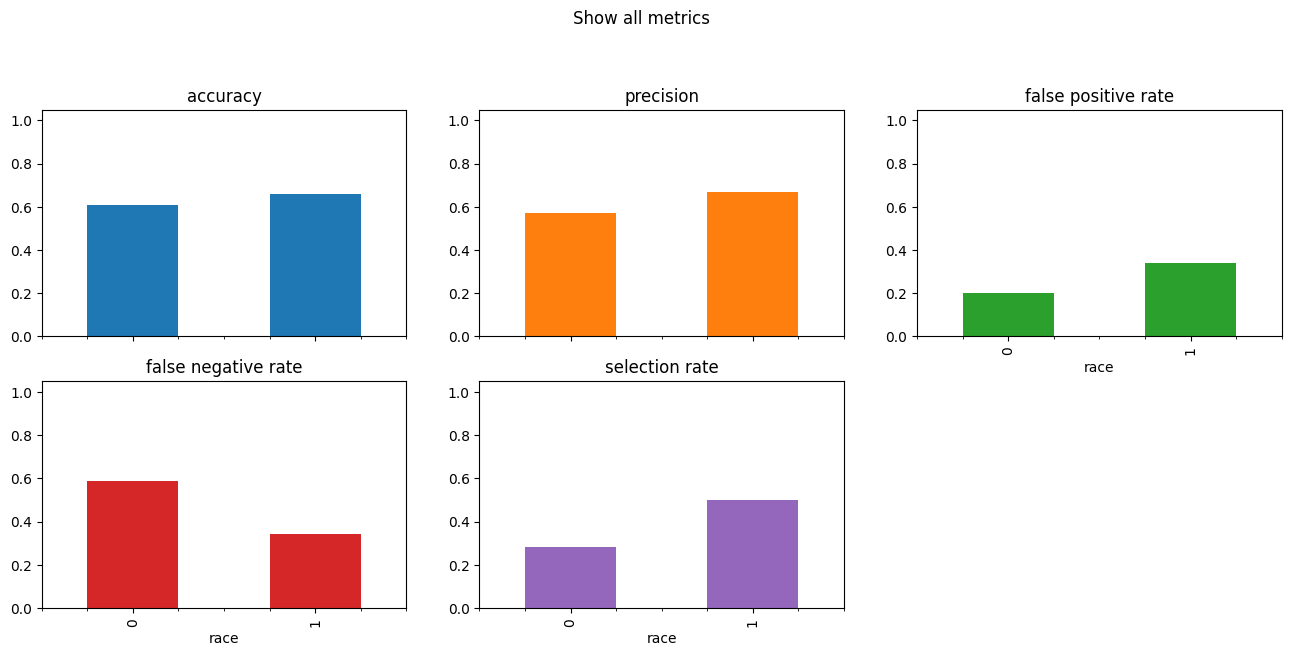

In [19]:
analyze_metrics_using_metricFrame(y_test, y_pred_gb, sensitive_feature_race)

In [20]:
statistical_parity_sex = statistical_parity(y_test, y_pred_gb, sensitive_feature_sex)
equalized_odds_sex = equalized_odds(y_test, y_pred_gb, sensitive_feature_sex)

print(statistical_parity_sex)
print(equalized_odds_sex)

{'Statistical Parity Difference': 0.165, 'Statistical Parity ratio': 0.634}
{'Equalized Odds Difference': 0.21, 'Equalized Odds Ratio': 0.656}


array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='sex'>,
        <Axes: xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

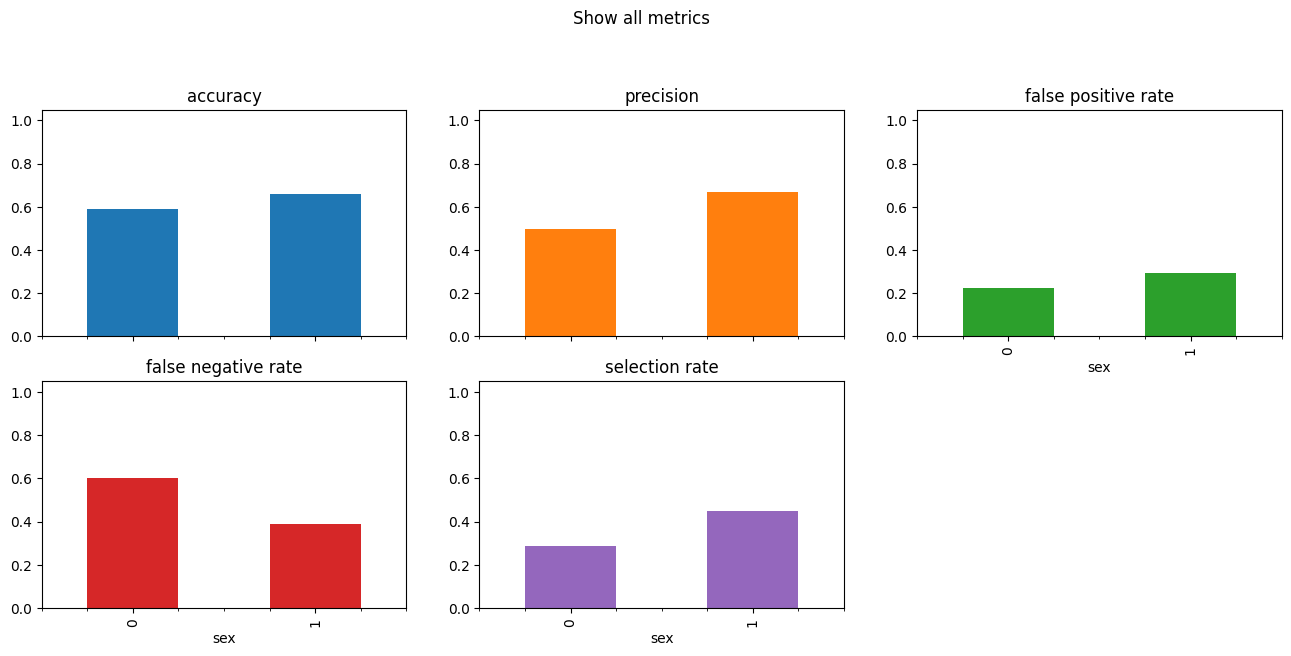

In [21]:
analyze_metrics_using_metricFrame(y_test, y_pred_gb, sensitive_feature_sex)

In [22]:
# Saving the results
results_df = update_results(
    mitigation_technique='Removing Race and Sex features from training data',
    model_accuracy=model_accuracy_gb,  
    AUC= AUC,  
    f1= f1, 
    precision= precision,  
    recall= recall, 
    statistical_parity_sex = statistical_parity_sex, 
    equalized_odds_sex = equalized_odds_sex,
    statistical_parity_race = statistical_parity_race, 
    equalized_odds_race = equalized_odds_race
)

/var/folders/h5/r3ldzs6x5bxb71r4t20ydphh0000gn/T/ipykernel_98906/2976667666.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return results_df.append(new_entry, ignore_index=True)


In [23]:
results_df

,mitigation_technique,model_accuracy,AUC,f1,precision,recall,statistical_parity_sex,equalized_odds_sex,statistical_parity_race,equalized_odds_race
0,none,0.660354,0.654931,0.612950,0.650382,0.579592,"{'Statistical Parity Difference': 0.2, 'Statistical Parity ratio': 0.56}","{'Equalized Odds Difference': 0.244, 'Equalized Odds Ratio': 0.605}","{'Statistical Parity Difference': 0.23, 'Statistical Parity ratio': 0.544}","{'Equalized Odds Difference': 0.263, 'Equalized Odds Ratio': 0.568}"
1,Removing Race and Sex features from training data,0.655303,0.650037,0.608321,0.643399,0.576871,"{'Statistical Parity Difference': 0.165, 'Statistical Parity ratio': 0.634}","{'Equalized Odds Difference': 0.21, 'Equalized Odds Ratio': 0.656}","{'Statistical Parity Difference': 0.218, 'Statistical Parity ratio': 0.565}","{'Equalized Odds Difference': 0.247, 'Equalized Odds Ratio': 0.593}"


**Key observation:** 
Removing race and sex as features from the training data resulted in a slight improvement in all fairness metrics for both race and sex, indicating a reduction in bias. The changes, however, are modest, suggesting that while direct reliance on sensitive attributes is reduced, proxy features might still be causing indirect bias.

#### 1.3.2 Feature importance after Removing Sex and Race

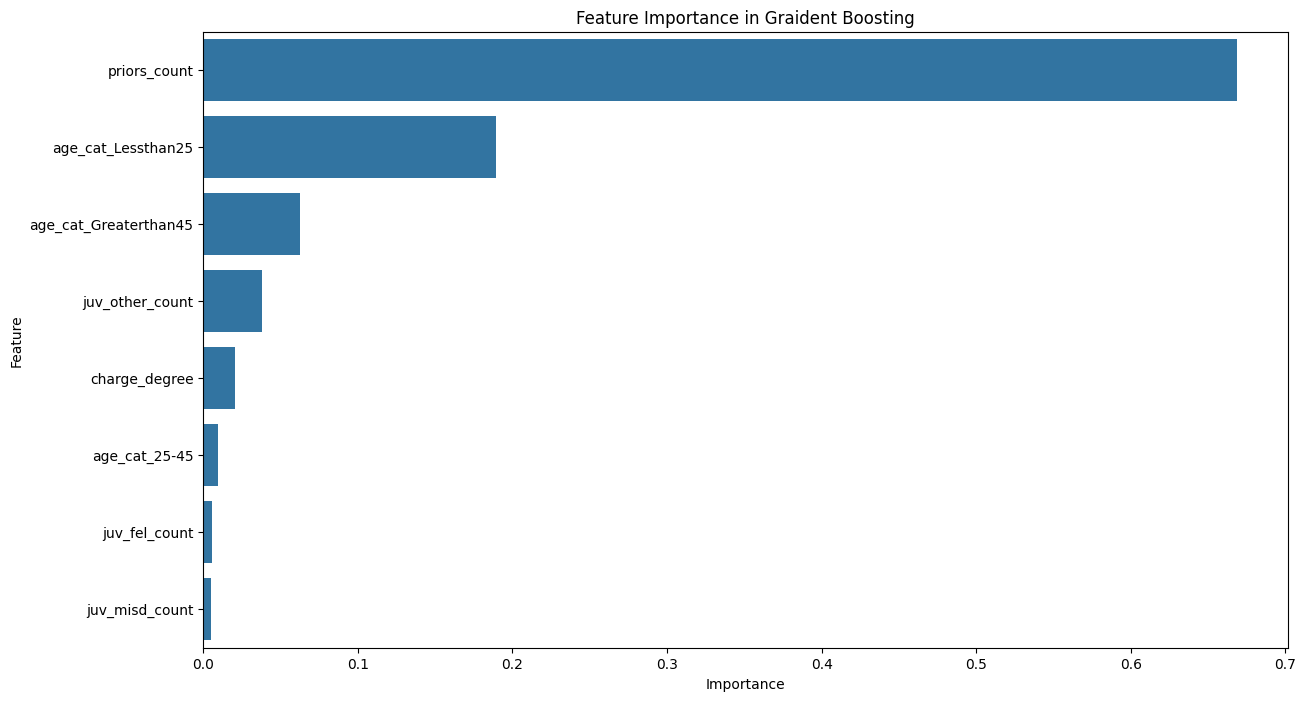

In [24]:
feature_importance = pd.DataFrame({
    'features': X_train.columns,
    'coefficients': gb_classifier.feature_importances_
})

feature_importance = feature_importance.sort_values(by='coefficients', ascending=False)


# Plotting the feature importance
plt.figure(figsize=(14, 8))
sns.barplot(x='coefficients', y='features', data=feature_importance)
plt.title('Feature Importance in Graident Boosting')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## 2. Investigating Class Imbalance Related to Sensitive Features

In [25]:
# Calculating the counts for race and sex in the dataset
race_counts = df['race'].value_counts()
sex_counts = df['sex'].value_counts()

print("Race class count: \n", race_counts, '\n')
print("Sex class count: \n", sex_counts)

Race class count: 
 1    3175
0    2103
Name: race, dtype: int64 

Sex class count: 
 1    4247
0    1031
Name: sex, dtype: int64


There is a class imbalance in both race and sex within this dataset. African Americans and males are overrepresented. 

### 2.1 Resampling

Through comprehensive data analysis exploring various combinations of upsampling and downsampling for race and sex, it was determined that the most effective resampling strategy is 'upsampling race followed by sex'. This conclusion is based on the assessment of fairness metrics, where 'upsampling race followed by sex' demonstrated the lowest aggregate differences and highest aggregate ratios in fairness measures.

In [26]:
# Upsampling RACE feature
group_1 = df[df['race'] == 1]
group_0 = df[df['race'] == 0]

# Function to resample each subgroup to have the same number of samples
def resample_group(df, group_size):
    return df.sample(n=group_size, replace=True, random_state=42)

max_group_size = max(len(group_0[group_0['two_year_recid'] == 1]), len(group_1[group_1['two_year_recid'] == 1]))

# Resample each group to have the same number of samples
group_0_recidivate = resample_group(group_0[group_0['two_year_recid'] == 1], max_group_size)
group_1_recidivate = resample_group(group_1[group_1['two_year_recid'] == 1], max_group_size)

group_0_not_recidivate = resample_group(group_0[group_0['two_year_recid'] == 0], max_group_size)
group_1_not_recidivate = resample_group(group_1[group_1['two_year_recid'] == 0], max_group_size)

# Combine the resampled data back
df_upsampled_race = pd.concat([group_0_recidivate, group_0_not_recidivate, group_1_recidivate, group_1_not_recidivate])

# Shuffle the resampled data
df_upsampled_race = df_upsampled_race.sample(frac=1).reset_index(drop=True)

# Upsampling SEX feature
group_1 = df_upsampled_race[df_upsampled_race['sex'] == 1]
group_0 = df_upsampled_race[df_upsampled_race['sex'] == 0]

# Function to resample each subgroup to have the same number of samples
def resample_group(df, group_size):
    return df.sample(n=group_size, replace=True, random_state=42)

max_group_size = max(len(group_0[group_0['two_year_recid'] == 1]), len(group_1[group_1['two_year_recid'] == 1]))

# Resample each group to have the same number of samples
group_0_recidivate = resample_group(group_0[group_0['two_year_recid'] == 1], max_group_size)
group_1_recidivate = resample_group(group_1[group_1['two_year_recid'] == 1], max_group_size)

group_0_not_recidivate = resample_group(group_0[group_0['two_year_recid'] == 0], max_group_size)
group_1_not_recidivate = resample_group(group_1[group_1['two_year_recid'] == 0], max_group_size)

# Combine the resampled data back
df_upsampled_race_sex_max = pd.concat([group_0_recidivate, group_0_not_recidivate, group_1_recidivate, group_1_not_recidivate])

# Shuffle the resampled data
df_upsampled_race_sex_max = df_upsampled_race_sex_max.sample(frac=1).reset_index(drop=True)


In [27]:
# Data Preparation
X = df_upsampled_race_sex_max.drop(['two_year_recid'], axis=1)
y = df_upsampled_race_sex_max['two_year_recid']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Remove sex and race from the training data
X_train = X_train.drop(['sex', 'race'], axis=1)
sensitive_feature_race = X_test['race']
sensitive_feature_sex = X_test['sex']
X_test = X_test.drop(['sex', 'race'], axis=1)

# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(learning_rate=0.01, 
                                           max_depth=3, 
                                           n_estimators=300, 
                                           random_state=42)

# Fit the grid search to the data
gb_classifier.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.01, n_estimators=300,
                           random_state=42)

In [28]:
# Evaluate the model on the test set
y_pred_gb = gb_classifier.predict(X_test)

model_accuracy_gb = accuracy_score(y_test, y_pred_gb)
AUC = roc_auc_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)

print("Test set accuracy: ", model_accuracy_gb)
print("Classification report:\n", classification_report(y_test, y_pred_gb))

Test set accuracy:  0.6331930246542393
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.63      0.64      1711
           1       0.62      0.64      0.63      1615

    accuracy                           0.63      3326
   macro avg       0.63      0.63      0.63      3326
weighted avg       0.63      0.63      0.63      3326



#### 2.1.1 Statistical Parity and Equalized Odds after resampling

In [29]:
statistical_parity_race = statistical_parity(y_test, y_pred_gb, sensitive_feature_race)
equalized_odds_race = equalized_odds(y_test, y_pred_gb, sensitive_feature_race)

print(statistical_parity_race)
print(equalized_odds_race)

{'Statistical Parity Difference': 0.165, 'Statistical Parity ratio': 0.717}
{'Equalized Odds Difference': 0.19, 'Equalized Odds Ratio': 0.59}


array([[<Axes: title={'center': 'accuracy'}, xlabel='race'>,
        <Axes: title={'center': 'precision'}, xlabel='race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='race'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='race'>,
        <Axes: title={'center': 'selection rate'}, xlabel='race'>,
        <Axes: xlabel='race'>],
       [<Axes: xlabel='race'>, <Axes: xlabel='race'>,
        <Axes: xlabel='race'>]], dtype=object)

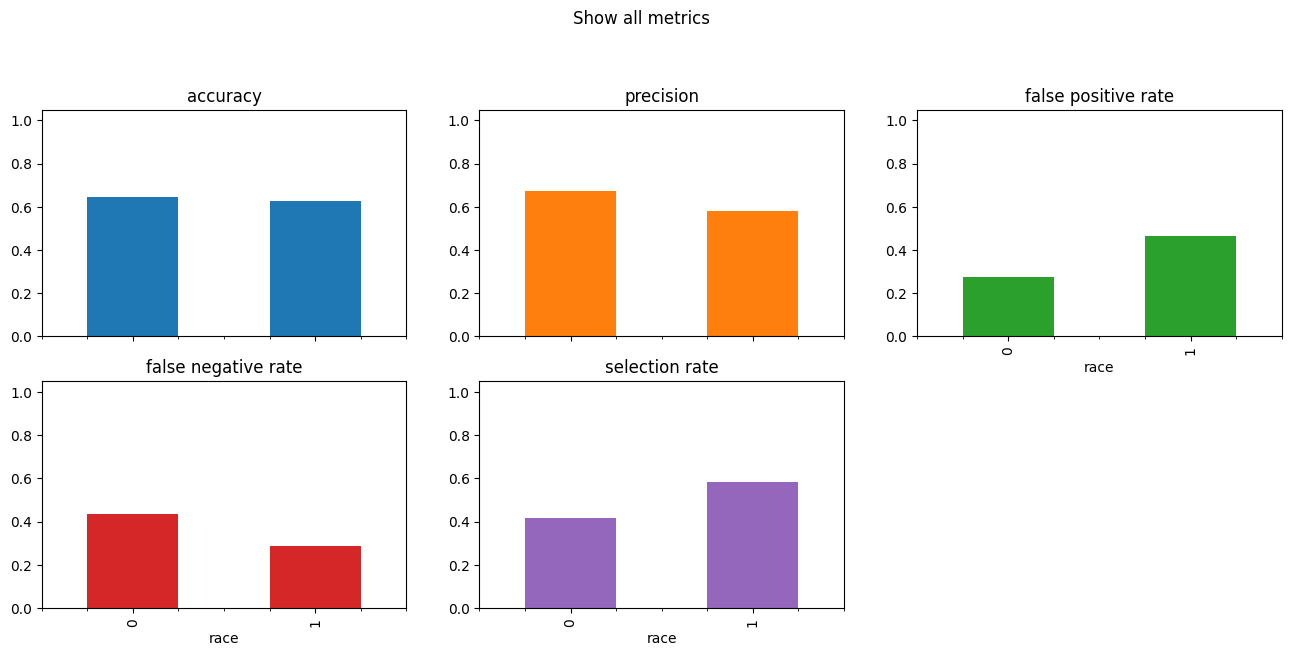

In [30]:
analyze_metrics_using_metricFrame(y_test, y_pred_gb, sensitive_feature_race)

In [31]:
statistical_parity_sex = statistical_parity(y_test, y_pred_gb, sensitive_feature_sex)
equalized_odds_sex = equalized_odds(y_test, y_pred_gb, sensitive_feature_sex)

print(statistical_parity_sex)
print(equalized_odds_sex)

{'Statistical Parity Difference': 0.09, 'Statistical Parity ratio': 0.834}
{'Equalized Odds Difference': 0.099, 'Equalized Odds Ratio': 0.815}


array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='sex'>,
        <Axes: xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

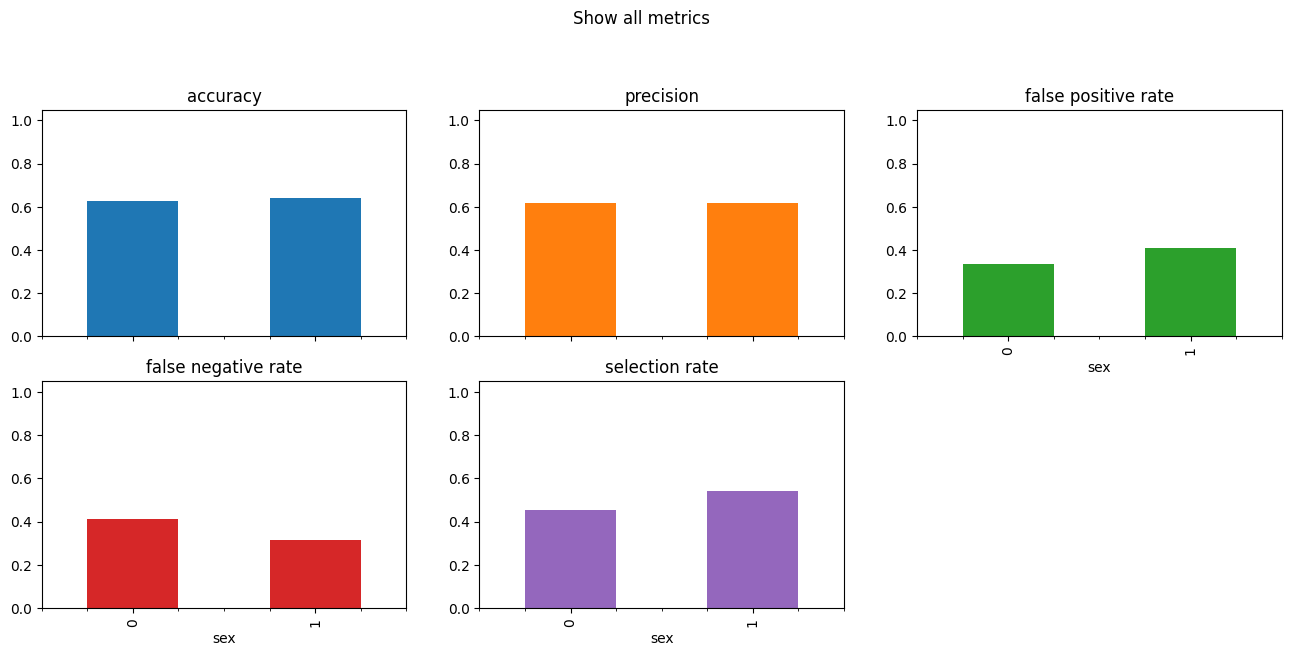

In [32]:
analyze_metrics_using_metricFrame(y_test, y_pred_gb, sensitive_feature_sex)

In [33]:
# Saving the results
results_df = update_results(
    mitigation_technique='Upsample Race followed by Sex',
    model_accuracy=model_accuracy_gb,  
    AUC= AUC,  
    f1= f1, 
    precision= precision,  
    recall= recall, 
    statistical_parity_sex = statistical_parity_sex, 
    equalized_odds_sex = equalized_odds_sex,
    statistical_parity_race = statistical_parity_race, 
    equalized_odds_race = equalized_odds_race
)

/var/folders/h5/r3ldzs6x5bxb71r4t20ydphh0000gn/T/ipykernel_98906/2976667666.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return results_df.append(new_entry, ignore_index=True)


In [34]:
results_df

,mitigation_technique,model_accuracy,AUC,f1,precision,recall,statistical_parity_sex,equalized_odds_sex,statistical_parity_race,equalized_odds_race
0,none,0.660354,0.654931,0.612950,0.650382,0.579592,"{'Statistical Parity Difference': 0.2, 'Statistical Parity ratio': 0.56}","{'Equalized Odds Difference': 0.244, 'Equalized Odds Ratio': 0.605}","{'Statistical Parity Difference': 0.23, 'Statistical Parity ratio': 0.544}","{'Equalized Odds Difference': 0.263, 'Equalized Odds Ratio': 0.568}"
1,Removing Race and Sex features from training data,0.655303,0.650037,0.608321,0.643399,0.576871,"{'Statistical Parity Difference': 0.165, 'Statistical Parity ratio': 0.634}","{'Equalized Odds Difference': 0.21, 'Equalized Odds Ratio': 0.656}","{'Statistical Parity Difference': 0.218, 'Statistical Parity ratio': 0.565}","{'Equalized Odds Difference': 0.247, 'Equalized Odds Ratio': 0.593}"
2,Upsample Race followed by Sex,0.633193,0.633287,0.627595,0.618904,0.636533,"{'Statistical Parity Difference': 0.09, 'Statistical Parity ratio': 0.834}","{'Equalized Odds Difference': 0.099, 'Equalized Odds Ratio': 0.815}","{'Statistical Parity Difference': 0.165, 'Statistical Parity ratio': 0.717}","{'Equalized Odds Difference': 0.19, 'Equalized Odds Ratio': 0.59}"


**Resampeling conclusion:** Upsampling race followed by sex with respect to the traget variable in an improvement in all fairness metrics for both race and sex, indicating a reduction in bias. 

#### 2.1.2 Feature importance after resampling the data

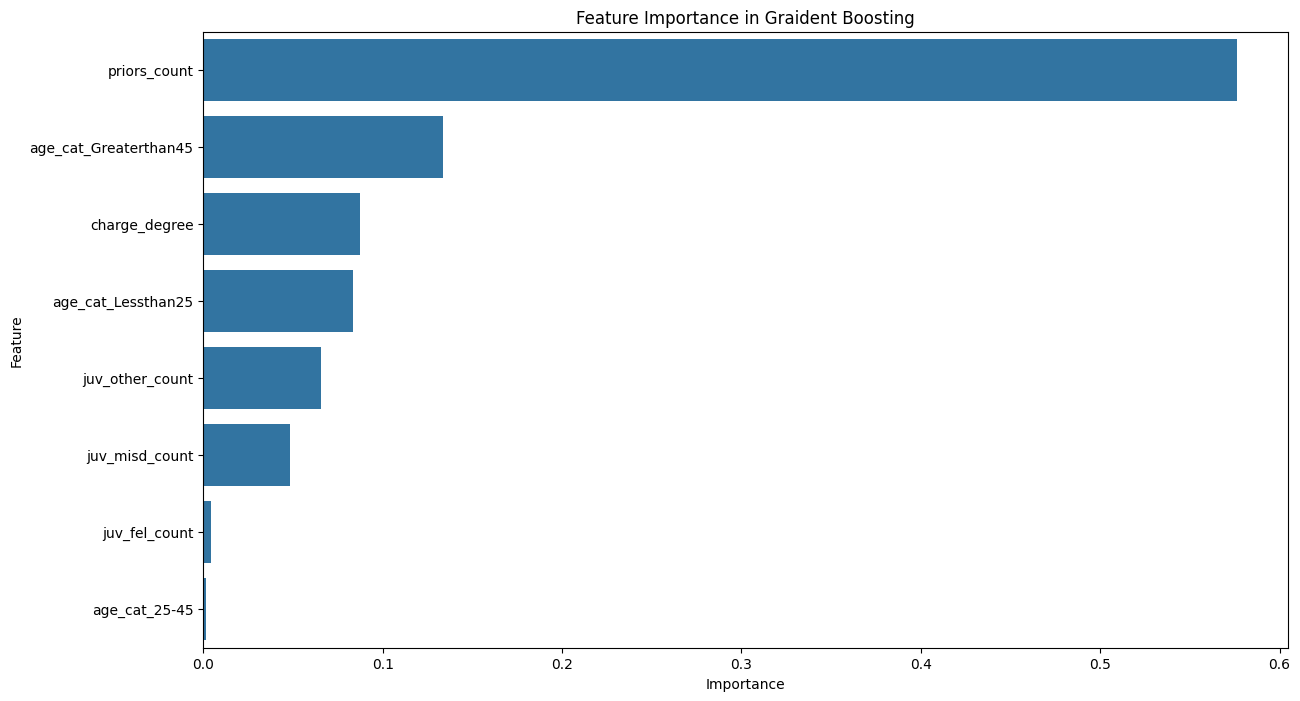

In [35]:
feature_importance = pd.DataFrame({
    'features': X_train.columns,
    'coefficients': gb_classifier.feature_importances_
})

feature_importance = feature_importance.sort_values(by='coefficients', ascending=False)


# Plotting the feature importance
plt.figure(figsize=(14, 8))
sns.barplot(x='coefficients', y='features', data=feature_importance)
plt.title('Feature Importance in Graident Boosting')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Key observiation:**
Upsampling the minority groups has improved the fairness metrics for sex, narrowing the gap in Statistical Parity and achieving a closer to equalized odds. For race, there's a notable improvement in Statistical Parity, indicating progress towards equal treatment across racial groups, but for both groups the metrics still show room for improvement, particularly in achieving equalized odds. These results suggest that upsampling can be an effective strategy for mitigating bias, but it may need to be combined with other techniques to address residual disparities fully.

## 3. In-processing Technique: Data Reweighting

In [36]:
from sklearn.utils.class_weight import compute_sample_weight

# Data Preparation
X = df_upsampled_race_sex_max.drop(['two_year_recid'], axis=1)
y = df_upsampled_race_sex_max['two_year_recid']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Remove sex and race from the training data
X_train = X_train.drop(['sex', 'race'], axis=1)
sensitive_feature_race = X_test['race']
sensitive_feature_sex = X_test['sex']
X_test = X_test.drop(['sex', 'race'], axis=1)

# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(learning_rate=0.01, 
                                           max_depth=3, 
                                           n_estimators=300, 
                                           random_state=42)

# Compute sample weights for reweighting the classes in the training data
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Fit the classifier to the data using the computed sample weights
gb_classifier.fit(X_train, y_train, sample_weight=sample_weights)


GradientBoostingClassifier(learning_rate=0.01, n_estimators=300,
                           random_state=42)

In [37]:
# Evaluate the model on the test set
y_pred_gb = gb_classifier.predict(X_test)

model_accuracy_gb = accuracy_score(y_test, y_pred_gb)
AUC = roc_auc_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)

print("Test set accuracy: ", model_accuracy_gb)
print("Classification report:\n", classification_report(y_test, y_pred_gb))

Test set accuracy:  0.6343956704750451
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.63      0.64      1711
           1       0.62      0.64      0.63      1615

    accuracy                           0.63      3326
   macro avg       0.63      0.63      0.63      3326
weighted avg       0.63      0.63      0.63      3326



In [38]:
statistical_parity_race = statistical_parity(y_test, y_pred_gb, sensitive_feature_race)
equalized_odds_race = equalized_odds(y_test, y_pred_gb, sensitive_feature_race)

print(statistical_parity_race)
print(equalized_odds_race)

{'Statistical Parity Difference': 0.162, 'Statistical Parity ratio': 0.72}
{'Equalized Odds Difference': 0.186, 'Equalized Odds Ratio': 0.596}


array([[<Axes: title={'center': 'accuracy'}, xlabel='race'>,
        <Axes: title={'center': 'precision'}, xlabel='race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='race'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='race'>,
        <Axes: title={'center': 'selection rate'}, xlabel='race'>,
        <Axes: xlabel='race'>],
       [<Axes: xlabel='race'>, <Axes: xlabel='race'>,
        <Axes: xlabel='race'>]], dtype=object)

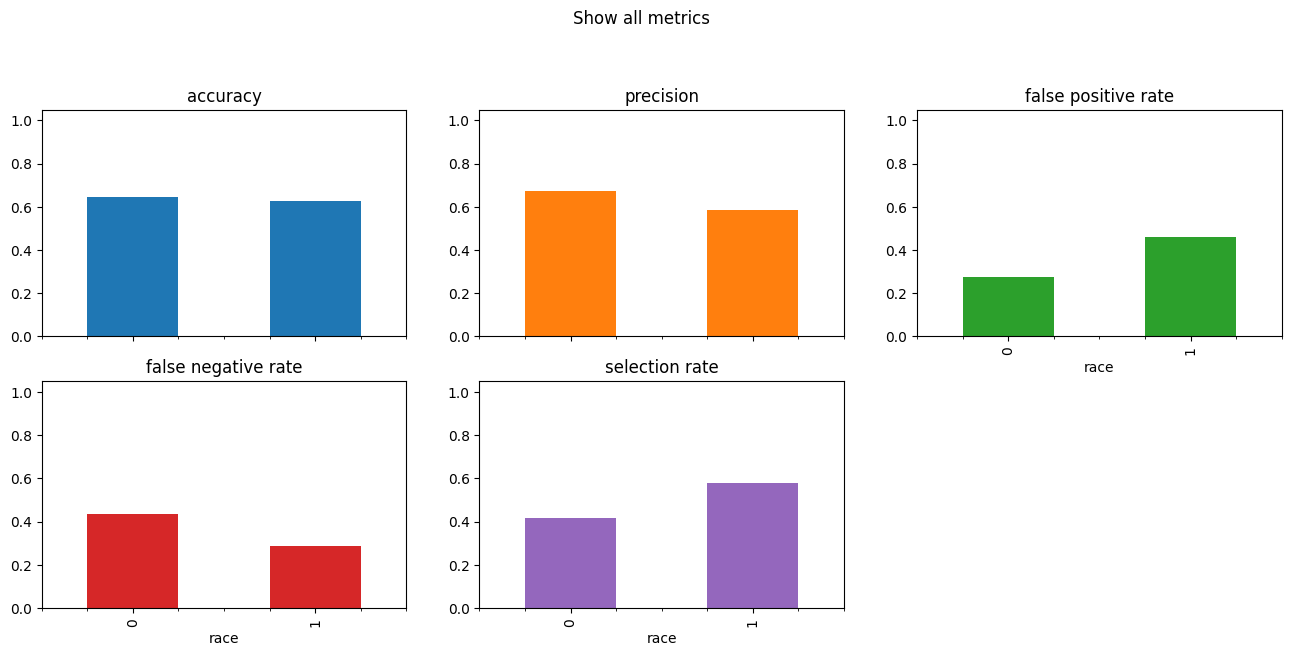

In [39]:
analyze_metrics_using_metricFrame(y_test, y_pred_gb, sensitive_feature_race)

In [40]:
statistical_parity_sex = statistical_parity(y_test, y_pred_gb, sensitive_feature_sex)
equalized_odds_sex = equalized_odds(y_test, y_pred_gb, sensitive_feature_sex)

print(statistical_parity_sex)
print(equalized_odds_sex)

{'Statistical Parity Difference': 0.093, 'Statistical Parity ratio': 0.83}
{'Equalized Odds Difference': 0.099, 'Equalized Odds Ratio': 0.803}


array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='sex'>,
        <Axes: xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

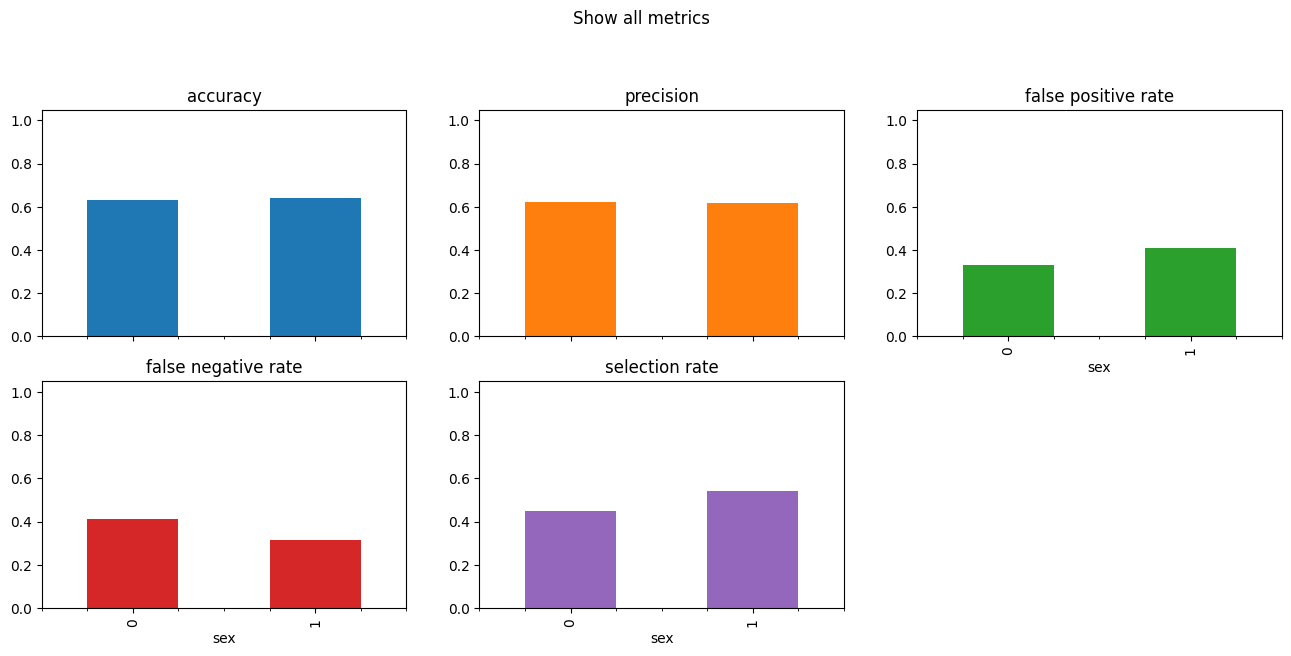

In [41]:
analyze_metrics_using_metricFrame(y_test, y_pred_gb, sensitive_feature_sex)

In [42]:
# Saving the results
results_df = update_results(
    mitigation_technique='Data re-weighting',
    model_accuracy=model_accuracy_gb,  
    AUC= AUC,  
    f1= f1, 
    precision= precision,  
    recall= recall, 
    statistical_parity_sex = statistical_parity_sex, 
    equalized_odds_sex = equalized_odds_sex,
    statistical_parity_race = statistical_parity_race, 
    equalized_odds_race = equalized_odds_race
)

/var/folders/h5/r3ldzs6x5bxb71r4t20ydphh0000gn/T/ipykernel_98906/2976667666.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return results_df.append(new_entry, ignore_index=True)


In [43]:
results_df

,mitigation_technique,model_accuracy,AUC,f1,precision,recall,statistical_parity_sex,equalized_odds_sex,statistical_parity_race,equalized_odds_race
0,none,0.660354,0.654931,0.612950,0.650382,0.579592,"{'Statistical Parity Difference': 0.2, 'Statistical Parity ratio': 0.56}","{'Equalized Odds Difference': 0.244, 'Equalized Odds Ratio': 0.605}","{'Statistical Parity Difference': 0.23, 'Statistical Parity ratio': 0.544}","{'Equalized Odds Difference': 0.263, 'Equalized Odds Ratio': 0.568}"
1,Removing Race and Sex features from training data,0.655303,0.650037,0.608321,0.643399,0.576871,"{'Statistical Parity Difference': 0.165, 'Statistical Parity ratio': 0.634}","{'Equalized Odds Difference': 0.21, 'Equalized Odds Ratio': 0.656}","{'Statistical Parity Difference': 0.218, 'Statistical Parity ratio': 0.565}","{'Equalized Odds Difference': 0.247, 'Equalized Odds Ratio': 0.593}"
2,Upsample Race followed by Sex,0.633193,0.633287,0.627595,0.618904,0.636533,"{'Statistical Parity Difference': 0.09, 'Statistical Parity ratio': 0.834}","{'Equalized Odds Difference': 0.099, 'Equalized Odds Ratio': 0.815}","{'Statistical Parity Difference': 0.165, 'Statistical Parity ratio': 0.717}","{'Equalized Odds Difference': 0.19, 'Equalized Odds Ratio': 0.59}"
3,Data re-weighting,0.634396,0.634456,0.628362,0.620398,0.636533,"{'Statistical Parity Difference': 0.093, 'Statistical Parity ratio': 0.83}","{'Equalized Odds Difference': 0.099, 'Equalized Odds Ratio': 0.803}","{'Statistical Parity Difference': 0.162, 'Statistical Parity ratio': 0.72}","{'Equalized Odds Difference': 0.186, 'Equalized Odds Ratio': 0.596}"


## 4. Testing Exponentiated Gradients for Fair Prediction

In [49]:
from fairlearn.reductions import DemographicParity, ExponentiatedGradient
from sklearn.pipeline import Pipeline

# Data Preparation
X = df_upsampled_race_sex_max.drop(['two_year_recid'], axis=1)
y = df_upsampled_race_sex_max['two_year_recid']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sensitive_features = X_train[['race', 'sex']]
X_train = X_train.drop(['sex', 'race'], axis=1)
sensitive_feature_race = X_test['race']
sensitive_feature_sex = X_test['sex']
X_test = X_test.drop(['sex', 'race'], axis=1)

pipeline = Pipeline(
    steps=[
        ("classifier", gb_classifier),
    ]
)

exponentiated_gradient = ExponentiatedGradient(
    estimator=pipeline,
    constraints=DemographicParity(),
    sample_weight_name="classifier__sample_weight"
)
exponentiated_gradient.fit(X_train, y_train, sensitive_features=sensitive_features)
y_pred_expG = exponentiated_gradient.predict(X_test)

In [51]:
# Measure accuracy
from sklearn.metrics import balanced_accuracy_score

accuracy = balanced_accuracy_score(y_test, y_pred_expG)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5938666758345652


In [53]:
model_accuracy_gb = accuracy_score(y_test, y_pred_expG)
AUC = roc_auc_score(y_test, y_pred_expG)
f1 = f1_score(y_test, y_pred_expG)
precision = precision_score(y_test, y_pred_expG)
recall = recall_score(y_test, y_pred_expG)

print("Test set accuracy: ", model_accuracy_gb)
print("Classification report:\n", classification_report(y_test, y_pred_gb))

Test set accuracy:  0.5947083583884546
Classification report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50      1711
           1       0.48      0.48      0.48      1615

    accuracy                           0.49      3326
   macro avg       0.49      0.49      0.49      3326
weighted avg       0.49      0.49      0.49      3326



In [54]:
statistical_parity_race = statistical_parity(y_test, y_pred_expG, sensitive_feature_race)
equalized_odds_race = equalized_odds(y_test, y_pred_expG, sensitive_feature_race)

print(statistical_parity_race)
print(equalized_odds_race)

{'Statistical Parity Difference': 0.033, 'Statistical Parity ratio': 0.932}
{'Equalized Odds Difference': 0.122, 'Equalized Odds Ratio': 0.721}


array([[<Axes: title={'center': 'accuracy'}, xlabel='race'>,
        <Axes: title={'center': 'precision'}, xlabel='race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='race'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='race'>,
        <Axes: title={'center': 'selection rate'}, xlabel='race'>,
        <Axes: xlabel='race'>],
       [<Axes: xlabel='race'>, <Axes: xlabel='race'>,
        <Axes: xlabel='race'>]], dtype=object)

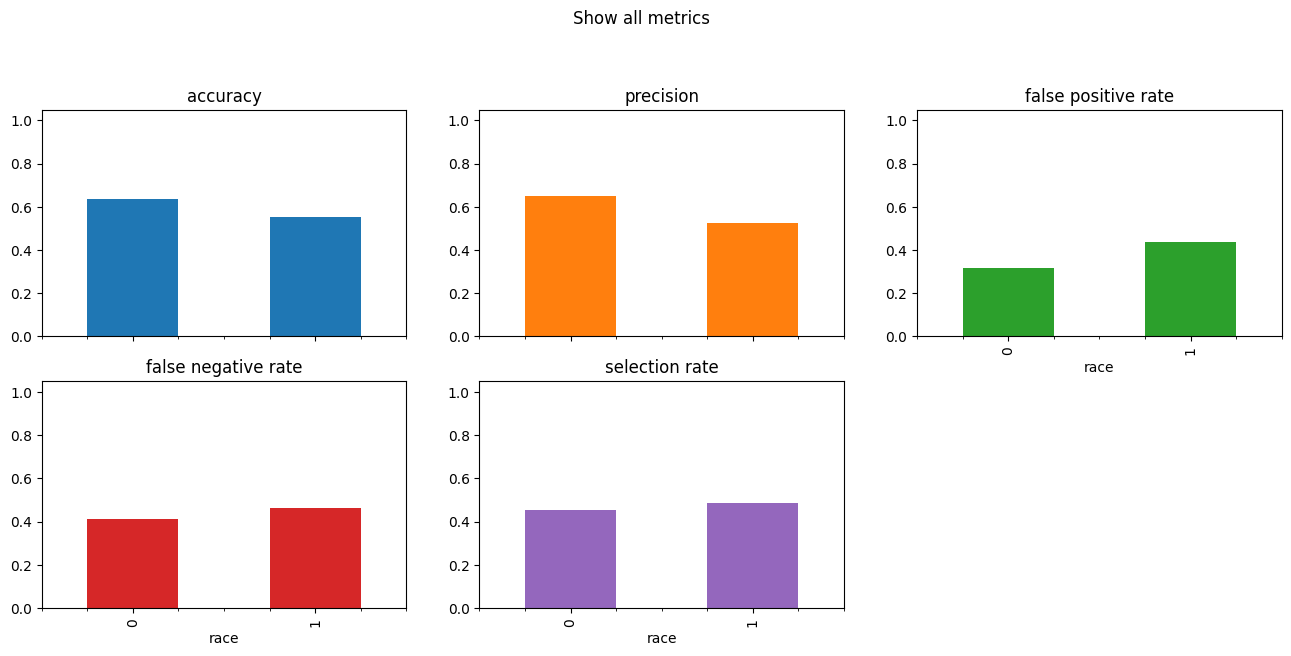

In [55]:
analyze_metrics_using_metricFrame(y_test, y_pred_expG, sensitive_feature_race)

In [56]:
statistical_parity_sex = statistical_parity(y_test, y_pred_expG, sensitive_feature_sex)
equalized_odds_sex = equalized_odds(y_test, y_pred_expG, sensitive_feature_sex)

print(statistical_parity_sex)
print(equalized_odds_sex)

{'Statistical Parity Difference': 0.018, 'Statistical Parity ratio': 0.963}
{'Equalized Odds Difference': 0.097, 'Equalized Odds Ratio': 0.773}


array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='sex'>,
        <Axes: xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

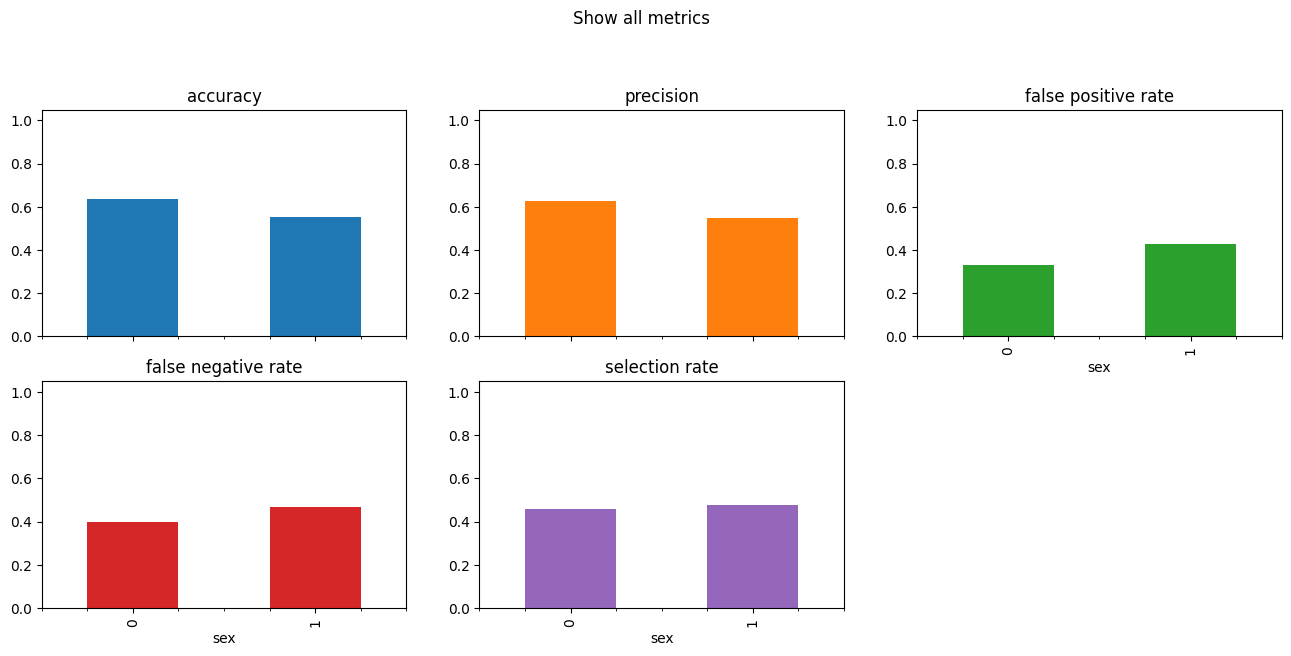

In [57]:
analyze_metrics_using_metricFrame(y_test, y_pred_expG, sensitive_feature_sex)

In [58]:
# Saving the results
results_df = update_results(
    mitigation_technique='Exponentiated Gradients',
    model_accuracy=model_accuracy_gb,  
    AUC= AUC,  
    f1= f1, 
    precision= precision,  
    recall= recall, 
    statistical_parity_sex = statistical_parity_sex, 
    equalized_odds_sex = equalized_odds_sex,
    statistical_parity_race = statistical_parity_race, 
    equalized_odds_race = equalized_odds_race
)

/var/folders/h5/r3ldzs6x5bxb71r4t20ydphh0000gn/T/ipykernel_98906/2976667666.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return results_df.append(new_entry, ignore_index=True)


In [59]:
results_df

,mitigation_technique,model_accuracy,AUC,f1,precision,recall,statistical_parity_sex,equalized_odds_sex,statistical_parity_race,equalized_odds_race
0,none,0.660354,0.654931,0.612950,0.650382,0.579592,"{'Statistical Parity Difference': 0.2, 'Statistical Parity ratio': 0.56}","{'Equalized Odds Difference': 0.244, 'Equalized Odds Ratio': 0.605}","{'Statistical Parity Difference': 0.23, 'Statistical Parity ratio': 0.544}","{'Equalized Odds Difference': 0.263, 'Equalized Odds Ratio': 0.568}"
1,Removing Race and Sex features from training data,0.655303,0.650037,0.608321,0.643399,0.576871,"{'Statistical Parity Difference': 0.165, 'Statistical Parity ratio': 0.634}","{'Equalized Odds Difference': 0.21, 'Equalized Odds Ratio': 0.656}","{'Statistical Parity Difference': 0.218, 'Statistical Parity ratio': 0.565}","{'Equalized Odds Difference': 0.247, 'Equalized Odds Ratio': 0.593}"
2,Upsample Race followed by Sex,0.633193,0.633287,0.627595,0.618904,0.636533,"{'Statistical Parity Difference': 0.09, 'Statistical Parity ratio': 0.834}","{'Equalized Odds Difference': 0.099, 'Equalized Odds Ratio': 0.815}","{'Statistical Parity Difference': 0.165, 'Statistical Parity ratio': 0.717}","{'Equalized Odds Difference': 0.19, 'Equalized Odds Ratio': 0.59}"
3,Data re-weighting,0.634396,0.634456,0.628362,0.620398,0.636533,"{'Statistical Parity Difference': 0.093, 'Statistical Parity ratio': 0.83}","{'Equalized Odds Difference': 0.099, 'Equalized Odds Ratio': 0.803}","{'Statistical Parity Difference': 0.162, 'Statistical Parity ratio': 0.72}","{'Equalized Odds Difference': 0.186, 'Equalized Odds Ratio': 0.596}"
4,Exponentiated Gradients,0.594708,0.593867,0.575032,0.585742,0.564706,"{'Statistical Parity Difference': 0.018, 'Statistical Parity ratio': 0.963}","{'Equalized Odds Difference': 0.097, 'Equalized Odds Ratio': 0.773}","{'Statistical Parity Difference': 0.033, 'Statistical Parity ratio': 0.932}","{'Equalized Odds Difference': 0.122, 'Equalized Odds Ratio': 0.721}"


## 5. Explaining Model Predictions with Global and Local Techniques

### 5.1 Global: feature importance

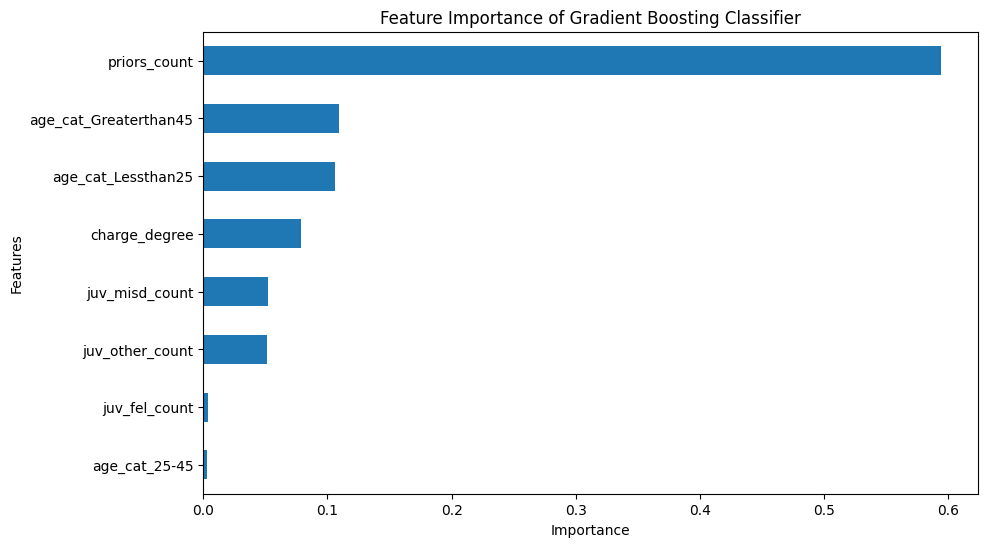

In [79]:
# Get feature importances from the model
feature_importances = gb_classifier.feature_importances_

# Create a pandas Series with the feature importances
feature_importance_series = pd.Series(feature_importances, index=X_train.columns)

# Sort the feature importances
feature_importance_series_sorted = feature_importance_series.sort_values()

# Plot the sorted feature importances
plt.figure(figsize=(10, 6))
feature_importance_series_sorted.plot(kind='barh')
plt.title('Feature Importance of Gradient Boosting Classifier')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


**Key observations:**

- The priors_count feature has the highest weight, indicating it has the strongest association with the outcome variable. In the context of recidivism prediction, this suggests that individuals with a higher number of prior offenses are more likely to reoffend, according to the model.
- The age categories age_cat_Lessthan25 and age_cat_Greaterthan45 show high weights, suggesting that age is a predictive factor for recidivism.
- The charge_degree feature also has a noticeable weight, implying that the severity of the charge (felony vs. misdemeanor) is an important predictor of recidivism.

- Features related to juvenile records are also influential but to a lesser extent compared to priors_count and age categories.

### 5.2 Local: LIME

In [81]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['No Recidivism', 'Recidivism'],
    discretize_continuous=True
)

# Choose an instance to explain
i = 10
exp = explainer.explain_instance(X_test.values[i], gb_classifier.predict_proba, num_features=10)

# Visualize the explanation for class 1 (Recidivism)
exp.show_in_notebook(show_table=True, show_all=False)

/Users/ghaithalseirawan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


## 6. Investigating Model Safety and Uncertainty

In [82]:
from sklearn.ensemble import BaggingClassifier

base_model = GradientBoostingClassifier(random_state=42)

# Data Preparation
X = df_upsampled_race_sex_max.drop(['two_year_recid'], axis=1)
y = df_upsampled_race_sex_max['two_year_recid']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Remove sex and race from the training data
X_train = X_train.drop(['sex', 'race'], axis=1)
sensitive_feature_race = X_test['race']
sensitive_feature_sex = X_test['sex']
X_test = X_test.drop(['sex', 'race'], axis=1)

# Initialize the Bagging Classifier
model_bagging = BaggingClassifier(estimator=base_model, n_estimators=100, n_jobs=-1, random_state=42)

# Compute sample weights for reweighting the classes in the training data
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Fit the classifier to the data using the computed sample weights
model_bagging.fit(X_train, y_train, sample_weight=sample_weights)

BaggingClassifier(estimator=GradientBoostingClassifier(random_state=42),
                  n_estimators=100, n_jobs=-1, random_state=42)

In [84]:
y_pred_bagging = model_bagging.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_bagging)
print(f"Accuracy of the BaggingClassifier on the Test Set: {accuracy:.2f}")

Accuracy of the BaggingClassifier on the Test Set: 0.64


In [99]:
import numpy as np

# Get the predictions from each base model in the ensemble
predictions = np.array([estimator.predict_proba(X_test)[:,1] for estimator in model_bagging.estimators_])

# Calculate the 5th and 95th percentiles of the predictions
lower_bound = np.percentile(predictions, 5, axis=0)
upper_bound = np.percentile(predictions, 95, axis=0)

median_predictions = np.median(predictions, axis=0)

/Users/ghaithalseirawan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/ghaithalseirawan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/ghaithalseirawan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/ghaithalseirawan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/ghaithalseirawan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warni

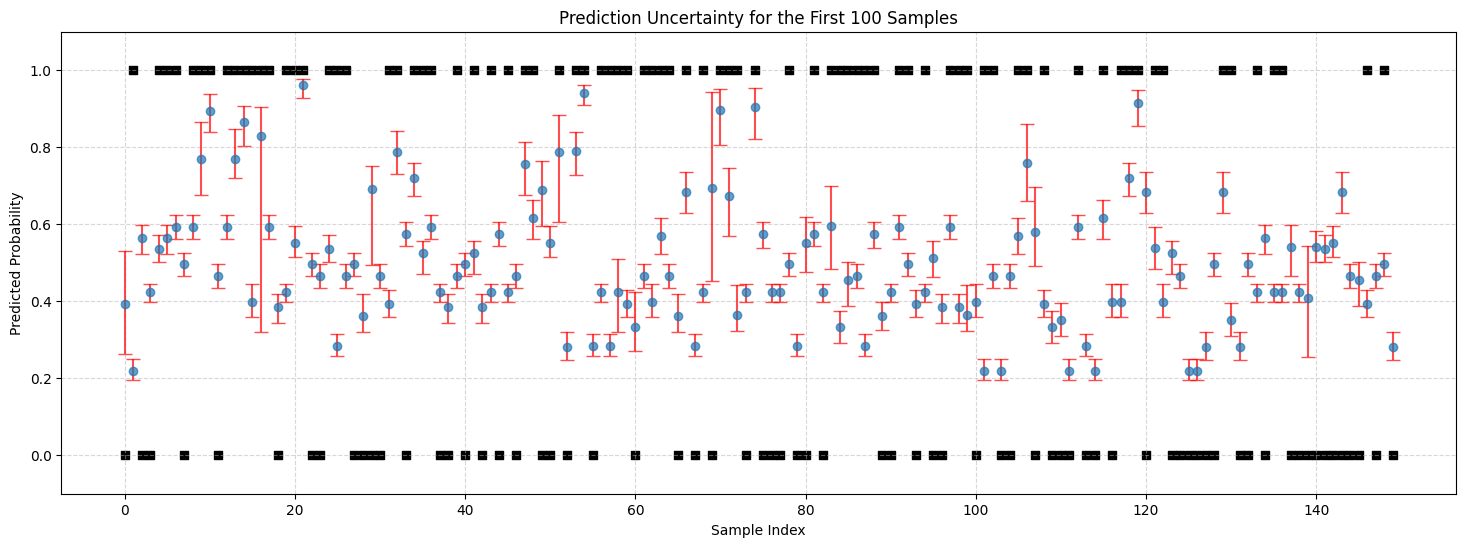

In [124]:
# Select the first 100 samples for visualization
sample_indices = range(150)  # Indices for the first 100 samples
predictions_subset = predictions[:, sample_indices]
y_test_subset = y_test.iloc[sample_indices]

# Calculate the 5th and 95th percentiles of the predictions for the subset
lower_bound_subset = np.percentile(predictions_subset, 5, axis=0)
upper_bound_subset = np.percentile(predictions_subset, 95, axis=0)
median_predictions_subset = np.median(predictions_subset, axis=0)

# Plot error bars for the first 100 predictions
plt.figure(figsize=[18,6])
plt.errorbar(sample_indices, median_predictions_subset, 
             yerr=[median_predictions_subset - lower_bound_subset, upper_bound_subset - median_predictions_subset], 
             fmt='o', capsize=5, ecolor='r', alpha=0.7)
plt.scatter(sample_indices, y_test_subset, marker='s', c='k')
plt.title('Prediction Uncertainty for the First 100 Samples')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.ylim(-0.1, 1.1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [129]:
threshold = 0.2
idx = upper_bound - lower_bound < threshold

accuracy = accuracy_score(y_test[idx], y_pred_bagging[idx])
decisiveness = sum(idx)/idx.shape[0]

print(f"The model can give us certain decisions about {decisiveness:.2f} of the test samples with the accuracy of: {accuracy:.2f}")

The model can give us certain decisions about 0.94 of the test samples with the accuracy of: 0.64


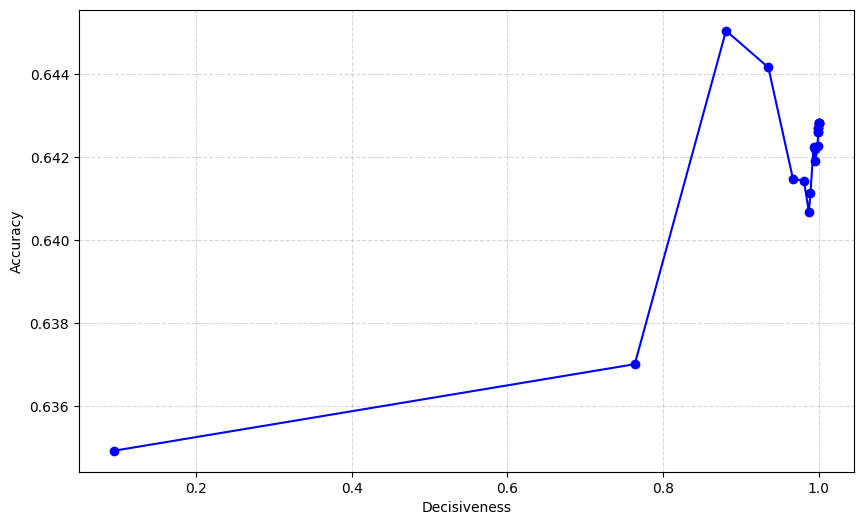

In [130]:
decisiveness_list = []
accuracy_list = []

thresholds = np.arange(0, 1.05, 0.05)
#print(thresholds.shape)

for threshold in thresholds:
    window = upper_bound - lower_bound < threshold
    #print(sum(window))
    if sum(window) == 0: continue
    
    accuracy = accuracy_score(y_test[window], model_bagging.predict(X_test[window]))
    decisiveness = sum(window)/window.shape[0]

    decisiveness_list.append(decisiveness)
    accuracy_list.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(decisiveness_list, accuracy_list, marker='o', linestyle='-', color='b')
plt.xlabel('Decisiveness')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()